# Demo: Matrix Conditioning and Uncertainties
MIT 6.336: Introduction to Numerical Simulation and Modelling

## Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../../")
import warnings
warnings.filterwarnings('ignore')

In [3]:
from quantumnetworks import MultiModeSystem, plot_full_evolution
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np


np.set_printoptions(suppress=True)

In [4]:
π = np.pi

def npArr(x, scale_factor = 1):
    return np.array(x) * scale_factor

def plot_cond(kerrs, conds, x_label = None, fig = None, ax = None):
    fig = fig if fig is not None else plt.figure(figsize=(4, 2.5), dpi=150)
    ax = ax if ax is not None else fig.subplots()
    
    ax.plot(kerrs, conds)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    fig.tight_layout()
    x_label = x_label if x_label is not None else r"Kerr $K$ (GHz)"
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(r"Cond. Number cond(A)")
    ax.set_title("Condition Number vs. Kerr")
    
def print_cond(A, name = None):

    name = name if name is not None else "A"
    c_A = np.linalg.cond(A)

    print(f"{name} = \n{A}\n")
    print(f"cond({name}) = {c_A:2e}")
    print("\n")

## A. Single Mode System

By the form of the $A$ matrix, we see a linear system will _never_ be ill-conditioned! Thus, we only need to worry about nonlinear systems. 

$$
A = \begin{bmatrix}
    -\frac{\kappa_a}{2} & \omega_a\\
    -\omega_a & -\frac{\kappa_a}{2}
\end{bmatrix} \qquad
A_{\rm nl}(q_0, p_0) = \begin{bmatrix}
    -\frac{\kappa_a}{2} + 4Kq_0p_0 & \omega_a + 2K(q_0^2+p_0^2)+4Kp_0^2 \\
    -\omega_a -2K (q_0^2 + p_0^2) - 4K q_0^2 & -\frac{\kappa_a}{2} - 4Kq_0 p_0
\end{bmatrix}
$$

### Sweep Condition Number vs. Kerr

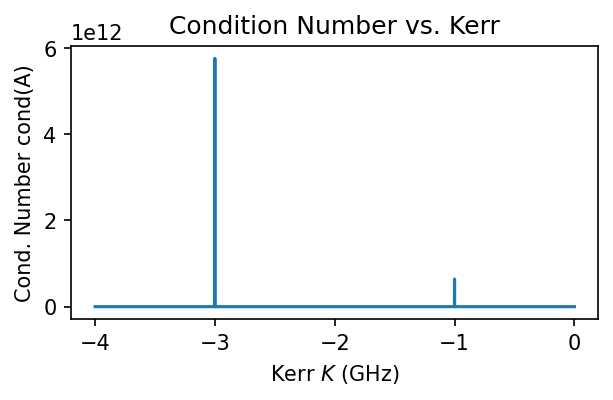

In [15]:
"""System Parameters in 2π × GHz"""
sf = 1  # scale factor
omegas = npArr([6], sf)
kappas = npArr([0.00001], sf)
gammas = npArr([0], sf)
couplings = []

KerrList = (-1) * np.arange(0, 4, 0.001) * sf
op = np.array([1, 0])

"""Sweep Kerr Values"""
conds = []
for k in KerrList:
    kerrs = [k]
    sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs": kerrs, "couplings":couplings})
    conds.append(np.linalg.cond(sys.A + sys.Jf_nl(op)))

"""Plot condition number"""
plot_cond(KerrList / sf, conds)

### Display Matrix and Condition Number + Time-Evolution

In [7]:
"""System Parameters in 2π × GHz"""
sf = 1  # scale factor
omegas = npArr([6.0], sf)
kappas = npArr([0.01], sf)
gammas = npArr([0.0], sf)
couplings = []
kerrs = npArr([0.0], sf)
op = np.array([1.0, 0.0])

"""Setup System and Plot Time Dynamics"""
sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs": kerrs, "couplings":couplings})

plot_evolution = False
if plot_evolution:
    x_0 = np.array(op)
    ts = np.linspace(0, 20, 100001)
    X = sys.forward_euler(x_0, ts)
    fig, ax = plot_full_evolution(X, ts, labels=["$q_a$","$p_a$"])
    ax.legend()


"""Display Matrices and Condition Number"""
A = sys.A
A_nl = A + sys.Jf_nl(op)
print_cond(A_nl, "A_nl")


A_nl_inv = np.linalg.inv(A_nl)
c_A_nl_direct = np.sqrt(np.max(np.linalg.eigvals(np.transpose(A_nl) @ A_nl))) * \
                     np.sqrt(np.max(np.linalg.eigvals(np.transpose(A_nl_inv) @ A_nl_inv)))
print(f"c(A_nl) = {c_A_nl_direct:2e} (direct calculation)")


A_nl = 
[[-0.005  6.   ]
 [-6.    -0.005]]

cond(A_nl) = 1.000000e+00


c(A_nl) = 1.000000e+00 (direct calculation)


### Analytic Calculations

For a single-mode system with no internal loss, we have
$$
A_{\rm nl}(q_0, p_0) = \begin{bmatrix}
    -\frac{\kappa_a}{2} + 4Kq_0p_0 & \omega_a + 2K(q_0^2+p_0^2)+4Kp_0^2 \\
    -\omega_a -2K (q_0^2 + p_0^2) - 4K q_0^2 & -\frac{\kappa_a}{2} - 4Kq_0 p_0
\end{bmatrix}.
$$

We can see that the diagonals of this matrix will be small whenever the 'loss' term $\kappa_a \simeq 0$. This is something of a necessary condition for ill-conditioning. We also note that if the system is entirely linear ($K=0$), then no ill-conditioning can occur by construction --- so another necessary condition is nonlinearity. Now, if either $q_0$ or $p_0$ is zero (but not both), then the two diagonals automatically vanish. The matrix will thus be ill conditioned whenever either of the remaining off diagonals vanish. This happens at two points: 
$$
    -\omega_a -2K (q_0^2 + p_0^2) - 4K q_0^2 \simeq 0 \quad\Longleftrightarrow\quad K \simeq \frac{-\omega_a}{2(q_0^2 + p_0^2) + 4q_0^2}
$$
and
$$
    \omega_a + 2K (q_0^2 + p_0^2) + 4K p_0^2 \simeq 0 \quad\Longleftrightarrow\quad K \simeq \frac{-\omega_a}{2(q_0^2 + p_0^2) + 4p_0^2}
$$

More generally, arbitrary $q_0, p_0$ (with not both zero). Then, we can search for ill-conditioning whenever the rows/columns are linearly dependent, which will occur when $\det(A_{\rm nl}) = 0$, i.e.
$$
    (4Kq_0p_0)^2 = \Big(\omega_a + 2K(q_0^2+p_0^2)+4Kp_0^2\Big)\Big(\omega_a +2K (q_0^2 + p_0^2) + 4K q_0^2\Big)
$$
or, equivalently,
$$
    (4Kq_0p_0)^2 = \Big(\omega_a + 2K(q_0^2+3p_0^2)\Big)\Big(\omega_a +2K (3q_0^2 + p_0^2)\Big)
$$
or,
$$
    \Big[4(q_0^2+3p_0^2)(3q_0^2 + p_0^2) - 16q_0^2p_0^2\Big]K^2 + \Big[8\omega_a (q_0^2 + p_0^2)\Big]K + \omega_a^2 = 0
$$
The two solutions $K_+$ and $K_-$ of this equation are the two singular points of the system. By construction, _both_ of these solutions will always be negative. 



**Other Notes and Observations:**
- For linear systems (i.e. kerr K = 0), the matrix A is always well conditioned by construction and `c(A)` ~ 1. 


- For non-linear `SingleModeSystem`, we need **negative** kerr (K < 0) in order to be able to find a singular operating point. 
    - If loss is nearly zero (i.e. κa ~ 0 and γa = 0), then the terms (κa + γa)/2 in the diagonals of A_nl nearly vanish. Then, for certain values of kerr K and operating point (q0, p0), the rows/columns become linearly dependent. **See calculation above**
    - E.g. if (q0, p0) = (1, 0), then we find `c(A_nl)` ~ 1e9 (i.e. _gets very large_) near K = -ωa / 6, and then again `c(A_nl)` ~ 1e10 near K = -ωa / 2

In [10]:
"""Solving the quadratic equation"""
omega = 6; q0 = 1; p0 = 0

Aq = 4*(q0**2 + 3*p0**2)*(3*q0**2 + p0**2) - 16*q0**2 * p0**2
Bq = 8*omega*(q0**2 + p0**2)
Cq = omega**2

print("Singular A_nl when Kerr K is:")
print([(-Bq - np.sqrt(Bq**2 - 4*Aq*Cq)) / (2*Aq), (-Bq + np.sqrt(Bq**2 - 4*Aq*Cq)) / (2*Aq)])

Singular A_nl when Kerr K is:
[-3.0, -1.0]


### Equivalence of `det` and `cond` for $2\times 2$ Matrices

**Lemma.** Consider an arbitrary $A \in M_{2\times 2}(\mathbb{R})$, i.e. $$A = \begin{pmatrix} a & b \\ c & d\end{pmatrix}.$$ Then, $${\rm cond} (A) = \frac{\Lambda}{\det(A)}, \quad\text{with}\,\,\, \Lambda = \frac{1}{2}\Big[(a^2 + b^2 + c^2 + d^2) + \sqrt{(a^2 + b^2 + c^2 + d^2) - 4(a^2d^2 + b^2 c^2 - 2abcd)}\Big]$$

where ${\rm cond} (A) = |\!|{A}|\!|_2|\!|{A}^{-1}|\!|_2$ is defined via the $2$-norm. In particular, when $A$ becomes ill-conditioned, then ${\rm cond} (A) \to \infty$ as $\det(A) \to 0$. 


**_Proof._** To be written up! 


## B. Double Mode System

### Plot Condition Number vs. Kerr

In [ ]:
"""System Parameters in 2π × GHz"""
sf = 1  # scale factor
omegas = npArr([6, 7], sf)
kappas = npArr([0.001, 0.001], sf)
gammas = npArr([0, 0], sf)
couplings = npArr([[0, 1, 2]], sf)

kerr_A = -2 * sf
kerr_B = (-1) * np.arange(2.4,2.6, 0.001) * sf
op = np.array([1, 0, 1, 0])

"""Sweep Kerr Values"""
conds = []
for k in kerr_B:
    kerrs = [kerr_A, k]
    sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs": kerrs, "couplings":couplings})
    conds.append(np.linalg.cond(sys.A + sys.Jf_nl(op)))

"""Plot condition number"""
plot_cond(kerr_B / sf, conds, r"Kerr $K_b$ (GHz)")


In [ ]:
# Heuristic check!

x = npArr([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
y = npArr([3.5, 3.49, 3.46, 3.41, 3.34, 3.25, 3.14, 3.01, 2.86, 2.69, 2.5], -1)

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)
ax.plot(x, y)
ax.set_xlabel(r"$g_{ab}$")
ax.set_ylabel(r"$K_b$ at singular value")
ax.set_title(r"[$\omega_a, \omega_b$] = [6, 7]; $\,\kappa_a = \kappa_b = 10^{-3};\,$ $K_a$ = -2.")

ax.plot(x, -3.5 + 0.25*x**2, linestyle='dashed')

plt.show()

### Display Matrix and Condition Number

In [ ]:
"""System Parameters in 2π × GHz"""
sf = 1  # scale factor
omegas = npArr([6, 7], sf)
kappas = npArr([0.00000001, 0.00000001], sf)
gammas = npArr([0, 0], sf)
couplings = npArr([[0, 1, 0.2]], sf)

kerrs = npArr([0, -3.49], sf)
op = np.array([1, 0, 1, 0])


"""Setup System and Display Matrices"""
sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs": kerrs, "couplings":couplings})

A = sys.A
A_nl = A + sys.Jf_nl(op)
print_cond(A_nl, "A_nl")

In [ ]:
np.linalg.det(A_nl)

### Analytic Calculations

For a double-mode system with no internal loss, we have
\begin{align*}
&A_{\rm nl}(q_a, p_a, q_b, p_b) \\ &= \begin{bmatrix}
    -\frac{\kappa_a}{2} + 4K_aq_ap_a & \omega_a + 2K_a(q_a^2+p_a^2)+4K_ap_a^2 & 0 & g_{ab} \\
    -\omega_a -2K_a (q_a^2 + p_a^2) - 4K_a q_a^2 & -\frac{\kappa_a}{2} - 4K_aq_a p_a & -g_{ab} & 0 \\
    0 & g_{ab} & -\frac{\kappa_b}{2} + 4K_bq_bp_b & \omega_b + 2K_b(q_b^2+p_b^2)+4K_bp_b^2 \\
    -g_{ab} & 0 & -\omega_b -2K_b (q_b^2 + p_b^2) - 4K_b q_b^2 & -\frac{\kappa_b}{2} - 4K_bq_b p_b \\
\end{bmatrix}.
\end{align*}




**Notes and other Observations**
- For linear systems (i.e. Kerr $K = 0$), the matrix `A` _should_ always be well conditioned by construction and `c(A)` ~ 1. 

- For a non-linear `DoubleModeSystem`, we need **negative** kerr ($K < 0$) in order to be able to find a singular operating point. We also need a low $\kappa_a, \kappa_b$. Additionally, changing $g_{ab}$ seems to affect the Kerr at which ill-conditioning occurs, and also decreases the actual condition number we see at this point. 
- Matrix $A_{\rm nl}$ will be ill-conditioned if either of its diagonal blocks are ill-conditioned! 

## 3 Mode System

In [ ]:
# 3 mode system
omegas = [1,2,1]
kappas = [0.001,0.005,0.001]
gammas = [0.002,0.002,0.002]
kerrs = [0.001, 0.001, 0.001]
couplings = [[0,1,0.002],[1,2,0.002]]
sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs":kerrs, "couplings":couplings})
print(np.around(sys.A, decimals=4))